# 01. Data preparation

1. Load raw dataframes
2. *Normalize per team*
3. *Cluster team data*
4. Combine with FM data

**Normalize per team:**

We will normalize stats per each team. The point is that a defensive player of a stronger team might have more attacking stats than an attacking player of a weaker team just because of overall possession and tactics. Team information would be passed as a cluster type, but for the purpose of stats analysis it is best to have information about a player from within the team, how important their contribution is for the team

**Cluster team data:**

Mean statistics grouped by team would be used to cluster teams. The cluster will then be used as a feature to evaluate players

In [33]:
# change wd to repo home
import os
if os.getcwd().split('\\')[-1] == 'notebooks':
    os.chdir('..')

In [34]:
from modules.fm_functions import *
import warnings
warnings.filterwarnings(action='ignore')

## Combine all FBRef data into one dataframe

In [35]:
import pandas as pd

In [85]:
season = '2023'

# load FBRef data in separate dfs
fbref_dfs = {filename : pd.read_csv(f'data/FBRef_split/{filename}', index_col=0)
             for filename in os.listdir('data/FBRef_split')
             if filename.split('_')[-1][:4] == season}

In [86]:
fbref_dfs.keys()

dict_keys(['Bundesliga_defense_2023-2024.csv', 'Bundesliga_gca_2023-2024.csv', 'Bundesliga_keepersadv_2023-2024.csv', 'Bundesliga_keepers_2023-2024.csv', 'Bundesliga_misc_2023-2024.csv', 'Bundesliga_passing_2023-2024.csv', 'Bundesliga_passing_types_2023-2024.csv', 'Bundesliga_playingtime_2023-2024.csv', 'Bundesliga_possession_2023-2024.csv', 'Bundesliga_shooting_2023-2024.csv', 'Bundesliga_stats_2023-2024.csv', 'EPL_defense_2023-2024.csv', 'EPL_gca_2023-2024.csv', 'EPL_keepersadv_2023-2024.csv', 'EPL_keepers_2023-2024.csv', 'EPL_misc_2023-2024.csv', 'EPL_passing_2023-2024.csv', 'EPL_passing_types_2023-2024.csv', 'EPL_playingtime_2023-2024.csv', 'EPL_possession_2023-2024.csv', 'EPL_shooting_2023-2024.csv', 'EPL_stats_2023-2024.csv', 'LaLiga_defense_2023-2024.csv', 'LaLiga_gca_2023-2024.csv', 'LaLiga_keepersadv_2023-2024.csv', 'LaLiga_keepers_2023-2024.csv', 'LaLiga_misc_2023-2024.csv', 'LaLiga_passing_2023-2024.csv', 'LaLiga_passing_types_2023-2024.csv', 'LaLiga_playingtime_2023-2024.cs

In [88]:
# combine FBRef dfs by type first
table_types = ['defense', 'gca', 'keepersadv', 'keepers', 'misc', 'passingtypes',
               'passing', 'playingtime', 'possession', 'shooting', 'stats']

fbref_dfs_types = {}

for t in table_types:
    fbref_dfs_types[t] = {}
    for k in fbref_dfs.keys():
        if k.split('_')[1] == t:
            fbref_dfs_types[t][k.split('_')[0]] = fbref_dfs[k]
    try:
        fbref_dfs_types[t] = pd.concat(fbref_dfs_types[t], axis=0, ignore_index=True).set_index(['_Player', '_Squad', '_Born'])
    except:
        print(t)

passingtypes


In [ ]:
# combine FBRef dfs into one
fbref_combined_df = pd.concat(fbref_dfs_types, axis=1).reset_index()
fbref_combined_df.columns = fbref_combined_df.columns.map(lambda x: '_'.join(map(str, x)))

In [ ]:
# store a complete FBRef file
fbref_combined_df.to_csv(f'data/{season}_FBRef_combined.csv')

## Normalize each column selection by team

In [59]:
from sklearn.preprocessing import MinMaxScaler

Drop players with fewer than 500 minutes

In [60]:
fbref_combined_filtered_df = fbref_combined_df[fbref_combined_df['playingtime_PlayingTime_Min']>=500]

In [61]:
# function to apply Min-Max scaling based on selected group and per-90 minutes stats
def group_minmax_scaling(group):
    scaler = MinMaxScaler()
    # Divide each column by 'playingtime_PlayingTime_Min' except for 'playingtime_PlayingTime_Min' itself
    for column in all_stats_columns:
        if column != 'playingtime_PlayingTime_Min' and column in group.columns:
            group[column] = group[column] / group['playingtime_PlayingTime_Min']
    # Apply Min-Max scaling
    group[all_stats_columns] = scaler.fit_transform(group[all_stats_columns])
    return group

In [62]:
fbref_normalized_df = fbref_combined_filtered_df.groupby('_Squad_', as_index=False).apply(group_minmax_scaling)

## Cluster teams

**to do: PCA instead of clusters** 

In [63]:
fbref_teams_df = fbref_combined_filtered_df.groupby('_Squad_')[all_stats_columns].mean()

In [64]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [65]:
team_scaler = StandardScaler()
fbref_teams_scaled = team_scaler.fit_transform(fbref_teams_df.values)

In [66]:
import seaborn as sns

n_clusters = {}
for k in range(1,11):
    team_clusters_kmeans = KMeans(n_clusters=k)
    team_clusters_kmeans.fit(fbref_teams_scaled)
    n_clusters[k] = team_clusters_kmeans.inertia_

<Axes: >

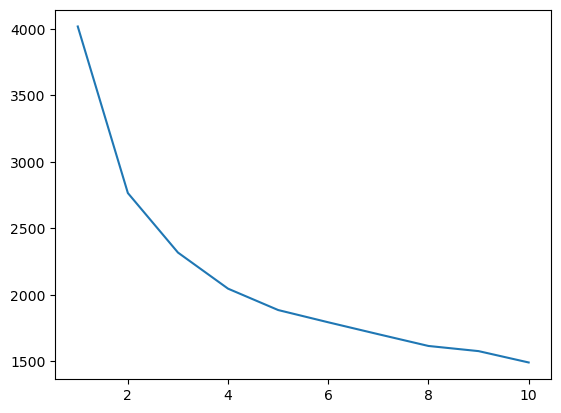

In [67]:
sns.lineplot(n_clusters)

In [68]:
team_clusters_kmeans = KMeans(n_clusters=4)

team_clusters = team_clusters_kmeans.fit_predict(fbref_teams_scaled)

fbref_teams_df['cluster'] = team_clusters

In [69]:
fbref_normalized_df['team_cluster'] = fbref_teams_df.loc[fbref_normalized_df.loc[:, '_Squad_'], 'cluster'].values

In [70]:
fbref_normalized_df.reset_index(inplace=True, drop=True)

## Combine with FM data

In [71]:
# drop keepers
fbref_normalized_outfielders_df = fbref_normalized_df[fbref_normalized_df['stats__Pos']!='GK']

In [72]:
# load FM data
FM_data = pd.read_csv('./data/FM 2023.csv')

In [73]:
FM_data['YOB'] = pd.to_datetime(FM_data['Date of birth']).dt.year

In [74]:
# combine the two dataframes
combined_data = fbref_normalized_outfielders_df.drop_duplicates(['_Player_', '_Born_']).merge(right=FM_data, left_on=['_Player_', '_Born_'],
                                                                                              right_on=['Name', 'YOB'], how='inner')
combined_data = combined_data[['team_cluster'] + all_stats_columns + FM_columns]

In [75]:
# store the combined file
combined_data.to_csv(f'data/{season}_combined_data.csv')